Pruebas usando un modelo híbrido, usando una capa de atención y capas convolucionales unidimensionales.

Librerías

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, f1_score
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import load_model

Paths

In [29]:
# === Descarga local temporalmente ===
balanced_train_segments_path = "c:/Users/sbrxb/waveled/data/raw/balanced_train_segments.csv"
ontology_path = "c:/Users/sbrxb/waveled/data/raw/ontology.json"
dir_bal_train = "c:/Users/sbrxb/waveled/data/raw/bal_train" 
dir_eval = "c:/Users/sbrxb/waveled/data/raw/eval" 
class_labels_indices_path = "c:/Users/sbrxb/waveled/data/raw/class_labels_indices.csv"

## Dataframes

In [30]:
with open(balanced_train_segments_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Leer el archivo línea por línea y reconstruir las filas correctamente
fixed_rows = []
for line in lines[3:]:  
    parts = line.strip().split(",")  
    if len(parts) >= 4:  
        fixed_rows.append([parts[0], parts[1], parts[2], ",".join(parts[3:])]) 

# Crear un DataFrame
df_segments = pd.DataFrame(fixed_rows, columns=["YTID", "start_seconds", "end_seconds", "positive_labels"])

In [31]:
# Cargar el JSON ontology
with open(ontology_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Crear el DataFrame
df_ontology = pd.DataFrame(data)

keywords = ["music", "musical", "song", "instrument", "singing"]

# Crear expresión regular con OR entre palabras
pattern = "|".join(keywords)

# Crear la columna is_music basada en las palabras clave
df_ontology["is_music"] = df_ontology["name"].str.lower().str.contains(pattern).astype(int)

df_ontology.head()

,id,name,description,citation_uri,positive_examples,child_ids,restrictions,is_music
0,/m/0dgw9r,Human sounds,Sounds produced by the human body through the ...,,[],"[/m/09l8g, /m/01w250, /m/09hlz4, /m/0bpl036, /...",[abstract],0
1,/m/09l8g,Human voice,The human voice consists of sound made by a hu...,http://en.wikipedia.org/wiki/Human_voice,[],"[/m/09x0r, /m/07p6fty, /m/03qc9zr, /m/02rtxlg,...",[abstract],0
2,/m/09x0r,Speech,Speech is the vocalized form of human communic...,http://en.wikipedia.org/wiki/Speech,"[youtu.be/8uI9H5jGRV8?start=30&end=40, youtu.b...","[/m/05zppz, /m/02zsn, /m/0ytgt, /m/01h8n0, /m/...",[],0
3,/m/05zppz,"Male speech, man speaking",Speech uttered by an adult male human.,,"[youtu.be/6niRPYpLOpQ?start=30&end=40, youtu.b...",[],[],0
4,/m/02zsn,"Female speech, woman speaking",Speech uttered by an adult female human.,,"[youtu.be/4l05nCOnIRg?start=30&end=40, youtu.b...",[],[],0


In [32]:
# Cargar el CSV en un DataFrame
df_class_labels_indices = pd.read_csv(class_labels_indices_path)

df_class_labels_indices.head()

,index,mid,display_name
0,0,/m/09x0r,Speech
1,1,/m/05zppz,"Male speech, man speaking"
2,2,/m/02zsn,"Female speech, woman speaking"
3,3,/m/0ytgt,"Child speech, kid speaking"
4,4,/m/01h8n0,Conversation


In [33]:
# Merge entre 'class_labels_indices' y 'ontology'
df_ontology_labels = pd.merge(df_class_labels_indices, df_ontology, left_on='mid', right_on='id', how='left')

# Eliminamos las columnas 'mid' y 'display_name'
df_ontology_labels = df_ontology_labels.drop(columns=['mid', 'display_name'])

# Diccionario con los índices como claves y las id como valores
id_labels_dict = df_ontology_labels.set_index('index')['id'].to_dict()

# Establecemos 'index' como índice
df_ontology_labels.set_index('index', inplace=True)

df_ontology_labels.head()


,id,name,description,citation_uri,positive_examples,child_ids,restrictions,is_music
index,,,,,,,,
0,/m/09x0r,Speech,Speech is the vocalized form of human communic...,http://en.wikipedia.org/wiki/Speech,"[youtu.be/8uI9H5jGRV8?start=30&end=40, youtu.b...","[/m/05zppz, /m/02zsn, /m/0ytgt, /m/01h8n0, /m/...",[],0
1,/m/05zppz,"Male speech, man speaking",Speech uttered by an adult male human.,,"[youtu.be/6niRPYpLOpQ?start=30&end=40, youtu.b...",[],[],0
2,/m/02zsn,"Female speech, woman speaking",Speech uttered by an adult female human.,,"[youtu.be/4l05nCOnIRg?start=30&end=40, youtu.b...",[],[],0
3,/m/0ytgt,"Child speech, kid speaking","Speech uttered by a human child, i.e. a human ...",,"[youtu.be/iPIGoScYduI?start=210&end=220, youtu...",[],[],0
4,/m/01h8n0,Conversation,"Interactive, spontaneous spoken communication ...",http://en.wikipedia.org/wiki/Conversation,"[youtu.be/4FQxw_49xAk?start=30&end=40, youtu.b...",[],[],0


# Funciones para Preprocesamiento

In [34]:
@tf.function(reduce_retracing=True)
def parse_music_example(example_proto, music_ids, id_labels_dict, seq_length=10):
    """
    Procesa un ejemplo de música serializado en formato TFRecord.
    
    Args:
        example_proto: Ejemplo serializado en formato TFRecord
        music_ids: Tensor con los IDs de música que queremos detectar
        id_labels_dict: Diccionario que mapea índices numéricos a IDs semánticos
        seq_length: Longitud máxima de la secuencia de audio (default: 10)
        
    Returns:
        audio_embeddings: Tensor con los embeddings de audio normalizados y paddeados [seq_length, 128]
        is_music: Tensor float32 (0.0 o 1.0) indicando si el ejemplo contiene alguna música de interés
    """
    # Convertir el diccionario a tensor constante
    id_labels_tensor = tf.constant(list(id_labels_dict.values()))

    # Definición de características del TFRecord
    context_features = {
        "video_id": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.VarLenFeature(tf.int64)
    }
    sequence_features = {
        "audio_embedding": tf.io.FixedLenSequenceFeature([], tf.string)
    }

    # Parsear el ejemplo protobuf
    context, sequences = tf.io.parse_single_sequence_example(
        example_proto, context_features=context_features, sequence_features=sequence_features
    )

    # Procesamiento de embeddings de audio
    audio_embeddings = tf.io.decode_raw(sequences['audio_embedding'], tf.uint8)
    audio_embeddings = tf.reshape(audio_embeddings, [-1, 128])
    audio_embeddings = (tf.cast(audio_embeddings, tf.float32) - 127.5) / 127.5
    audio_embeddings = audio_embeddings[:seq_length]
    padding = [[0, seq_length - tf.shape(audio_embeddings)[0]], [0, 0]]
    audio_embeddings = tf.pad(audio_embeddings, padding)
    audio_embeddings.set_shape([seq_length, 128])

    # Procesamiento de etiquetas
    labels = tf.sparse.to_dense(context['labels'])

    # Convertir labels a IDs y comparar con music_ids
    id_labels = tf.gather(id_labels_tensor, labels)
    
    # Verificar si alguna etiqueta coincide con music_ids
    is_music = tf.reduce_any(tf.equal(tf.expand_dims(id_labels, -1), music_ids))
    
    return audio_embeddings, tf.cast(is_music, tf.float32)

In [35]:
def create_dataset(tfrecord_dir, music_ids, batch_size=32, seq_length=10, is_training=True):
    """
    Crea un pipeline de datos TensorFlow configurable para entrenamiento o evaluación.
    
    Args:
        tfrecord_dir: Ruta al directorio con archivos .tfrecord
        music_ids: Lista de IDs de música a detectar
        batch_size: Tamaño del batch (default: 32)
        seq_length: Longitud de secuencia para embeddings de audio (default: 10)
        is_training: Bool (True para dataset de entrenamiento, False para test) (default: True)
        
    Returns:
        Dataset configurado con la estructura:
        - audio_embeddings: [batch_size, seq_length, 128]
        - is_music: [batch_size] (0.0 o 1.0)
    """
    # Validación de archivos
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
    if not tfrecord_files:
        raise ValueError(f"No se encontraron archivos .tfrecord en {tfrecord_dir}")
        
    # Preprocesamiento de music_ids (convertir a tensor constante una sola vez)
    music_ids_tensor = tf.constant([str(id) for id in music_ids], dtype=tf.string)
    
    # Crear dataset base desde los archivos TFRecord
    dataset = tf.data.TFRecordDataset(tfrecord_files, num_parallel_reads=tf.data.AUTOTUNE)
    
    # Definir y aplicar función de parseo
    parse_fn = lambda x: parse_music_example(x, music_ids_tensor, id_labels_dict, seq_length)
    dataset = dataset.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    '''
    # Configuración específica por modo
    if is_training:
        # Aumento de datos (por revisar)
    '''
    
    # Creación de batches
    dataset = dataset.batch(batch_size)
    
    # Prefetch para ambos modos
    return dataset.prefetch(tf.data.AUTOTUNE)

# Función para crear el modelo

In [ ]:
def build_model(input_shape=(10, 128)):
    """
    Construye un modelo para clasificación de música basado en embeddings de audio.
    
    Args:
        input_shape: Forma de los datos de entrada (secuencia_length, embedding_dim) 
                    (default: (10, 128))
                    
    Returns:
        Modelo Keras compilado listo para entrenamiento
    """
    # Definición de la arquitectura del modelo
    inputs = layers.Input(shape=input_shape)
    
    # Capa de atención para dar más peso a features importantes
    x = layers.MultiHeadAttention(num_heads=2, key_dim=64)(inputs, inputs) # Mecanismo de atención multi-head para capturar relaciones temporales
    x = layers.BatchNormalization()(x) # Normalización para estabilizar entrenamiento
    
    # Bloques convolucionales
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x) # Reducción dimensional
    x = layers.Dropout(0.3)(x) # Regularización
    
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x) # Pooling global para vector de características
    
    # Capas densas
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x) # Mayor regularización en capas densas
    
    # Capa de salida
    outputs = layers.Dense(1, activation='sigmoid')(x) # Clasificación binaria
    
    # Construcción del modelo
    model = models.Model(inputs, outputs)
    
    # Compilación con métricas relevantes
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),  # AUC-Precision-Recall 
        tf.keras.metrics.Precision(name='precision'),      # Precisión en clase positiva (música)
        tf.keras.metrics.Recall(name='recall'),            # Sensibilidad
    ]
    )
    
    return model

# Función para entrenar el modelo

In [37]:
def train_model():
    """
    Función para entrenar un modelo de clasificación de música con:
    - Validación de datos de entrada
    - Balanceo de clases
    - Monitoreo de métricas clave
    - Manejo seguro de errores
    """
    # 1. Preparación de Datos
    # Carga de IDs de música desde el dataframe "df_ontology_labels"
    music_ids = set(df_ontology_labels[df_ontology_labels["is_music"] == 1]["id"].astype(str))

    # 2. Creación del Dataset
    full_dataset = create_dataset(dir_bal_train, music_ids)

    # Tamaño del Dataset
    count = 0
    for batch in full_dataset:
        count += len(batch)  # Tamaño real de cada batch
    dataset_size = count

    if dataset_size == 0:
        raise ValueError("El dataset de entrenamiento está vacío")

    # 3. División Train/Validation
    val_size = int(0.2 * dataset_size)
    train_ds = full_dataset.skip(val_size).shuffle(buffer_size=1000, seed=10)
    val_ds = full_dataset.take(val_size)

    # Verificación de estructuras
    print("\n=== Verificación de Estructuras ===")
    print("Train dataset element_spec:", train_ds.element_spec)
    print("Validation dataset element_spec:", val_ds.element_spec)

    # 4. Inspección de Datos
    print("\n=== Muestra de Datos ===")
    for x, y in train_ds.take(1):
        print("Forma de los features (X):", x.shape)
        print("Forma de los labels (y):", y.shape)
        print("Valores de ejemplo (y):", y.numpy())

    # 5. Análisis de Balance
    # Conteo de clases
    pos = 0
    neg = 0
    for _, y in full_dataset.unbatch():  
        if y.numpy() == 1.0:
            pos += 1
        else:
            neg += 1

    print("\n=== Distribución de Clases ===")
    print(f"Ejemplos positivos (música): {pos}")
    print(f"Ejemplos negativos (NO música): {neg}")

    total_samples = pos + neg 
    class_weight = {
        0: total_samples / (2 * neg),  # Peso para NO música
        1: total_samples / (2 * pos)    # Peso para música
    }
    print(f"\nPesos de clase para balanceo: {class_weight}")

    # 6. Creación del modelo
    model = build_model()

    # 7. Entrenamiento
    print("\n=== Iniciando Entrenamiento ===")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        class_weight=class_weight,
    )

    '''
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
        monitor='val_pr_auc',  
        mode='max',
        patience=5,
        restore_best_weights=True
        )
    ]
    '''

    return model, history

# Creación y entrenamiento del modelo

In [38]:
try:
    model, history = train_model()
except Exception as e:
    print(f"Error durante el entrenamiento: {e}")


=== Verificación de Estructuras ===
Train dataset element_spec: (TensorSpec(shape=(None, 10, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
Validation dataset element_spec: (TensorSpec(shape=(None, 10, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))

=== Muestra de Datos ===
Forma de los features (X): (32, 10, 128)
Forma de los labels (y): (32,)
Valores de ejemplo (y): [0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 0. 0.]

=== Distribución de Clases ===
Ejemplos positivos (música): 7499
Ejemplos negativos (NO música): 14661

Pesos de clase para balanceo: {0: 0.7557465384353046, 1: 1.477530337378317}

=== Iniciando Entrenamiento ===
Epoch 1/50
    415/Unknown 10s 11ms/step - loss: 0.4585 - pr_auc: 0.7371 - precision: 0.6484 - recall: 0.8079

c:\Users\sbrxb\waveled\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.4583 - pr_auc: 0.7373 - precision: 0.6486 - recall: 0.8081 - val_loss: 0.4009 - val_pr_auc: 0.8337 - val_precision: 0.7277 - val_recall: 0.8640
Epoch 2/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.3726 - pr_auc: 0.8220 - precision: 0.7145 - recall: 0.8732 - val_loss: 0.3740 - val_pr_auc: 0.8420 - val_precision: 0.7355 - val_recall: 0.8683
Epoch 3/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.3352 - pr_auc: 0.8529 - precision: 0.7378 - recall: 0.8936 - val_loss: 0.3712 - val_pr_auc: 0.8414 - val_precision: 0.7181 - val_recall: 0.8826
Epoch 4/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.3107 - pr_auc: 0.8758 - precision: 0.7437 - recall: 0.9178 - val_loss: 0.4304 - val_pr_auc: 0.8367 - val_precision: 0.7054 - val_recall: 0.8977
Epoch 5/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.3006 - pr_auc: 0.8754 - precision: 0.7359 - recall: 0.9220 - val_loss: 0.3671 - val_pr_auc: 0.8447 - val_precision: 0.7

In [39]:
# Guardar el modelo
#model.save("model.h5")  

# Gráficas de precisión y perdida

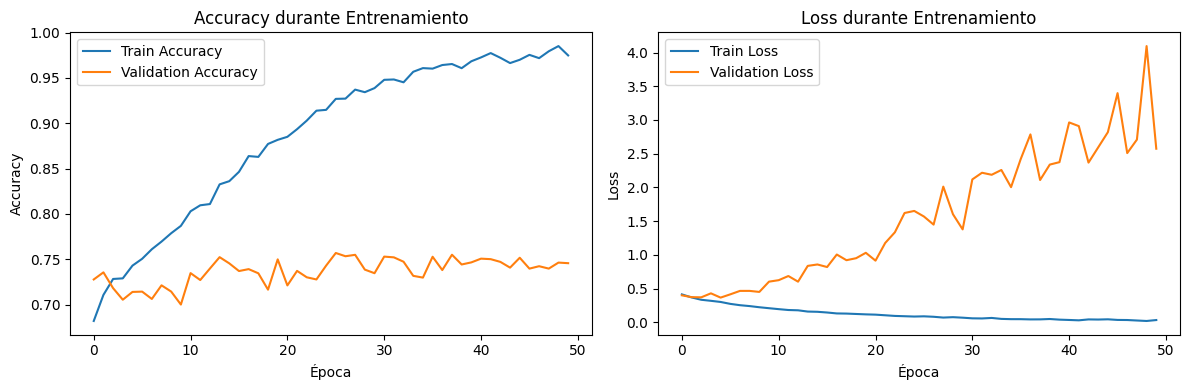

In [40]:
def plot_training_history(history):
    # Gráfica de Accuracy (si usaste 'accuracy' como métrica)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision'], label='Train Accuracy')
    plt.plot(history.history['val_precision'], label='Validation Accuracy')
    plt.title('Accuracy durante Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss durante Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Uso:
plot_training_history(history)

# Pruebas

## Crear el dataset

In [41]:
music_ids = set(df_ontology_labels[df_ontology_labels["is_music"] == 1]["id"].astype(str))

# Crear dataset de test
test_ds = create_dataset(
    tfrecord_dir=dir_eval,  
    music_ids=music_ids,
    batch_size=32
)

## Evaluación

In [42]:
# Evaluar el modelo
#model = tf.keras.models.load_model("model.h5")  # Cargar modelo entrenado
test_results = model.evaluate(test_ds, return_dict=True)
print("Resultados en Test:", test_results)

637/637 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4725 - pr_auc: 0.7513 - precision: 0.7527 - recall: 0.7453
Resultados en Test: {'loss': 2.4716343879699707, 'pr_auc': 0.7470535039901733, 'precision': 0.7448111176490784, 'recall': 0.737978994846344}


c:\Users\sbrxb\waveled\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


## Matriz de confusión

In [43]:
y_true = []
y_probs = []  

for x, y in test_ds.unbatch():
    y_true.append(y.numpy())
    y_probs.append(model.predict(tf.expand_dims(x, axis=0), verbose=0)[0][0])

y_true = np.array(y_true)
y_probs = np.array(y_probs)

# Umbral óptimo
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
optimal_idx = np.argmax(tpr - fpr)  
optimal_threshold = thresholds[optimal_idx]

print(f"\nUmbral óptimo según ROC: {optimal_threshold:.4f}")

y_pred_optimal = (y_probs > optimal_threshold).astype(int)

# Métricas con el nuevo umbral
print("\n=== Métricas con Umbral Óptimo ===")
print(classification_report(y_true, y_pred_optimal, target_names=["No música", "Música"]))

# Comparación con el umbral por defecto (0.5)
print("\n=== Métricas con Umbral=0.5 ===")
print(classification_report(y_true, (y_probs > 0.5).astype(int), target_names=["No música", "Música"]))

# Matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred_optimal)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción: No música', 'Predicción: Música'],
            yticklabels=['Real: No música', 'Real: Música'])
plt.title('Matriz de Confusión - Umbral Óptimo')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Para el umbral por defecto (0.5)
conf_mat_default = confusion_matrix(y_true, (y_probs > 0.5).astype(int))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_default, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción: No música', 'Predicción: Música'],
            yticklabels=['Real: No música', 'Real: Música'])
plt.title('Matriz de Confusión - Umbral=0.5')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

KeyboardInterrupt: 